In [13]:
!pip install keras-tuner

In [14]:
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import time
from tqdm.keras import TqdmCallback
from tqdm.notebook import tqdm
import keras_tuner as kt
import pandas as pd
import csv

In [15]:
num_classes = 32  # Number of classes in segmentation

# Function to print elapsed time
def print_time_elapsed(start_time, message):
    elapsed = time.time() - start_time
    print(f"\n{message} [Elapsed time: {elapsed:.2f} seconds]")

In [16]:
import os
import time
from sklearn.model_selection import train_test_split

# Start timer
start_time = time.time()

# Local paths to original + augmented datasets
image_dirs = [
    "/kaggle/input/images",           # original
    "/kaggle/input/aug-images"        # augmentate
]
mask_dirs = [
    "/kaggle/input/labels-index",     # original
    "/kaggle/input/mask-aug"     # augmentate salvate come .npy
]

# Costruzione liste unificate
image_paths = []
mask_paths = []

for img_dir in image_dirs:
    for fname in sorted(os.listdir(img_dir)):
        if fname.endswith('.png'):
            image_paths.append(os.path.join(img_dir, fname))

for mask_dir in mask_dirs:
    for fname in sorted(os.listdir(mask_dir)):
        if fname.endswith('.npy'):
            mask_paths.append(os.path.join(mask_dir, fname))

# Ordina per coerenza (importante se i nomi sono allineati)
image_paths = sorted(image_paths)
mask_paths = sorted(mask_paths)

# Verifica che il numero corrisponda
assert len(image_paths) == len(mask_paths), f"Mismatch: {len(image_paths)} images vs {len(mask_paths)} masks"

# Split train / val / test
train_img, temp_img, train_mask, temp_mask = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42)

val_img, test_img, val_mask, test_mask = train_test_split(
    temp_img, temp_mask, test_size=0.5, random_state=42)

def print_time_elapsed(start, msg=""):
    print(f"{msg} - Elapsed: {time.time() - start:.2f}s")

print_time_elapsed(start_time, f"Loaded {len(image_paths)} images and {len(mask_paths)} masks")
print_time_elapsed(start_time, "Data split completed")


Loaded 1062 images and 1062 masks - Elapsed: 0.02s
Data split completed - Elapsed: 0.02s


In [17]:
def load_image_mask(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, [512, 512])

    def load_npy(np_path):
        return np.load(np_path.decode('utf-8')).astype(np.uint8)

    mask = tf.numpy_function(load_npy, [mask_path], tf.uint8)
    mask.set_shape([512, 512])
    mask = tf.image.resize(mask[..., tf.newaxis], [512, 512], method='nearest')
    mask = tf.squeeze(mask, axis=-1)

    return img, mask

In [18]:
# Dice Loss
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_true = tf.cast(y_true, y_pred.dtype)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    dice = tf.reduce_mean(dice, axis=1)
    return 1 - tf.reduce_mean(dice)

# Wrapper per dice_loss con parametro smooth
def dice_loss_wrapper(smooth):
    def loss(y_true, y_pred):
        return dice_loss(y_true, y_pred, smooth=smooth)
    return loss

# Dice + CE Loss combinata
def dice_ce_loss(y_true, y_pred, alpha=0.5):
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    ce = tf.reduce_mean(ce)
    d_loss = dice_loss(y_true, y_pred)
    return alpha * ce + (1 - alpha) * d_loss

# Wrapper per dice_ce_loss con alpha tunabile
def dice_ce_loss_wrapper(alpha):
    def loss(y_true, y_pred):
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        ce = tf.reduce_mean(ce)
        d_loss = dice_loss(y_true, y_pred)
        return alpha * ce + (1 - alpha) * d_loss
    return loss

# Sparse Crossentropy (senza smoothing, non supportato!)
def sparse_crossentropy_loss(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

# Wrapper
def crossentropy_loss_wrapper():
    return sparse_crossentropy_loss

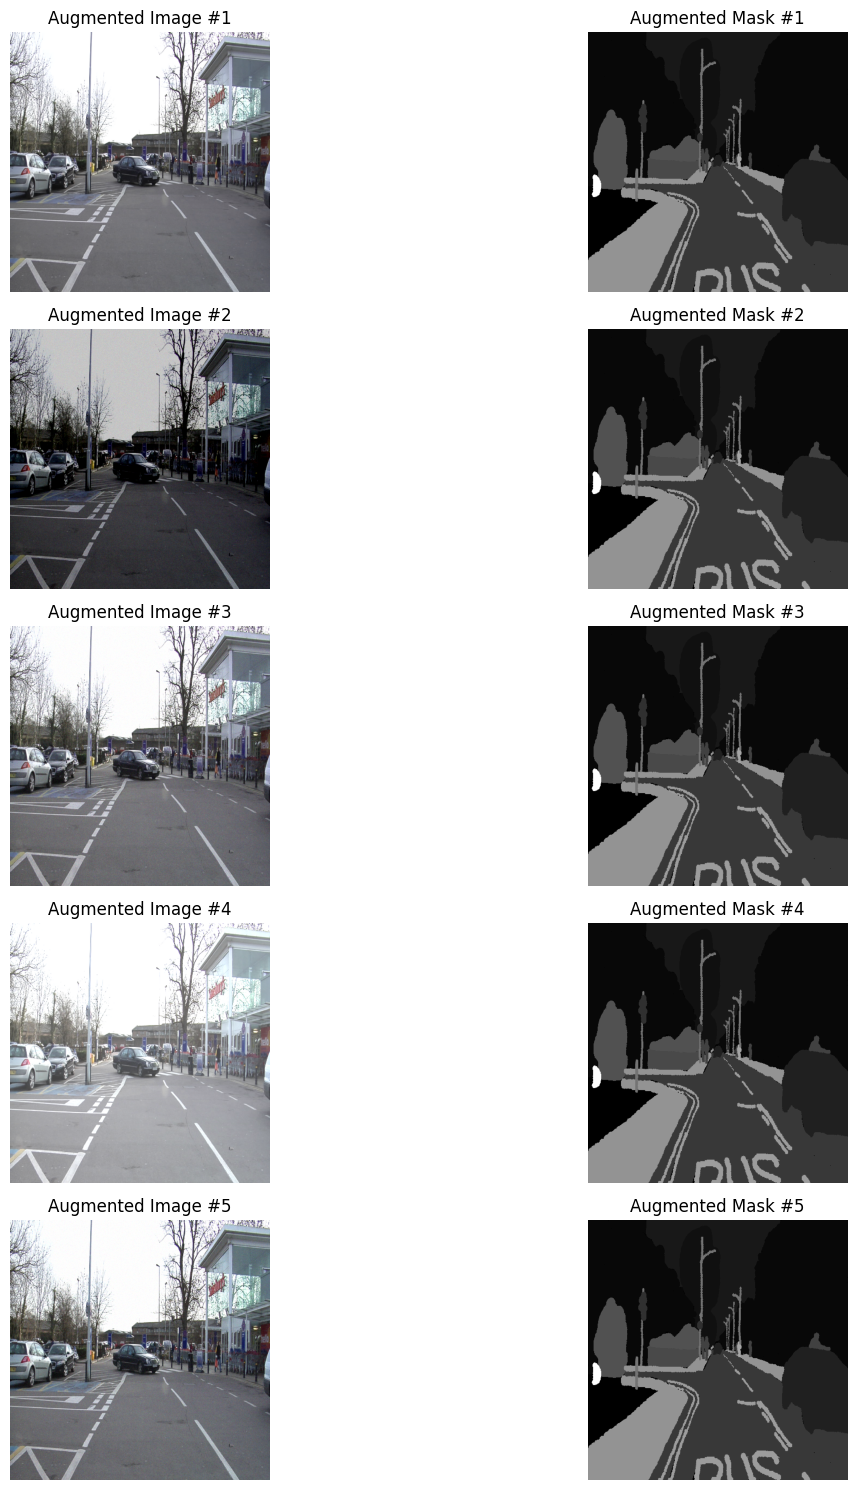

In [19]:
# Funzione di augmentation per immagine + maschera
def augment_image_mask(img, mask):

    # Luminosità
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_brightness(img, max_delta=0.3)

    # Contrasto
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    # Saturazione
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_saturation(img, lower=0.7, upper=1.3)

    # Hue
    if tf.random.uniform([]) < 0.5:
        img = tf.image.random_hue(img, max_delta=0.05)

    # Rumore gaussiano
    if tf.random.uniform([]) < 0.3:
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.02)
        img = tf.clip_by_value(img + noise, 0.0, 1.0)

    return img, mask


# Modifica la funzione create_dataset per includere l'augmentation opzionale
def create_dataset(img_paths, mask_paths, batch_size, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(img_paths))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Esempio di creazione dei dataset con augmentation solo sul train
batch_size = 8
train_ds = create_dataset(train_img, train_mask, batch_size, shuffle=True, augment=True)
val_ds = create_dataset(val_img, val_mask, batch_size, shuffle=False, augment=False)
test_ds = create_dataset(test_img, test_mask, batch_size, shuffle=False, augment=False)


# Funzioni per visualizzare l'augmentation (opzionale, utile per controllo)
def get_single_image_mask(dataset):
    for img_batch, mask_batch in dataset.take(1):
        img = img_batch[0]
        mask = mask_batch[0]
        return img, mask

def visualize_multiple_augmentations(img, mask, augment_func, times=5):
    plt.figure(figsize=(15, 3 * times))
    for i in range(times):
        aug_img, aug_mask = augment_func(img, mask)

        plt.subplot(times, 2, i*2+1)
        plt.imshow(aug_img.numpy())
        plt.title(f"Augmented Image #{i+1}")
        plt.axis('off')

        plt.subplot(times, 2, i*2+2)
        plt.imshow(aug_mask.numpy(), cmap='gray')
        plt.title(f"Augmented Mask #{i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Esempio di visualizzazione (facoltativo)
img, mask = get_single_image_mask(train_ds)
visualize_multiple_augmentations(img, mask, augment_image_mask, times=5)

In [20]:
class ArgmaxMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='iou', **kwargs):
        super(ArgmaxMeanIoU, self).__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)  # Use argmax to convert logits/probs to predicted class
        return super().update_state(y_true, y_pred, sample_weight)

In [21]:
class InstanceNormalization(keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[-1]
        self.gamma = self.add_weight(
            shape=(dim,),
            initializer="ones",
            trainable=True,
            name="gamma"
        )
        self.beta = self.add_weight(
            shape=(dim,),
            initializer="zeros",
            trainable=True,
            name="beta"
        )

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

In [22]:
def attention_gate(x, g, inter_channels):
    """
    x: skip connection from encoder (high resolution)
    g: gating signal from decoder (low resolution)
    inter_channels: number of intermediate filters
    """
    theta_x = Conv2D(inter_channels, 1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, 1, strides=1, padding='same')(g)
    add = Add()([theta_x, phi_g])
    act = Activation('relu')(add)
    psi = Conv2D(1, 1, strides=1, padding='same')(act)
    psi = Activation('sigmoid')(psi)
    
    # Assicuriamoci che psi abbia dimensioni uguali a x
    # Se necessario, facciamo upsampling
    if psi.shape[1] != x.shape[1] or psi.shape[2] != x.shape[2]:
        psi = UpSampling2D(
            size=(
                x.shape[1] // psi.shape[1], 
                x.shape[2] // psi.shape[2]
            )
        )(psi)
    
    y = Multiply()([x, psi])
    return y

In [23]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Add,Multiply, MaxPooling2D, Activation, Concatenate, Input
from tensorflow.keras.layers import SpatialDropout2D

def create_model(base_filters=16):
    
    input_shape = (512, 512, 3)
    num_classes = 32
    base_filters = 16
    
    inputs = Input(shape=input_shape)
    
    # Encoder
    c1 = Conv2D(base_filters, 3, padding='same')(inputs)
    c1 = InstanceNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(base_filters, 3, padding='same')(c1)
    c1 = InstanceNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = SpatialDropout2D(0.2)(c1)
    p1 = MaxPooling2D(2)(c1)  # 256x256
    
    c2 = Conv2D(base_filters*2, 3, padding='same')(p1)
    c2 = InstanceNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(base_filters*2, 3, padding='same')(c2)
    c2 = InstanceNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = SpatialDropout2D(0.2)(c2)
    p2 = MaxPooling2D(2)(c2)  # 128x128
    
    c3 = Conv2D(base_filters*4, 3, padding='same')(p2)
    c3 = InstanceNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(base_filters*4, 3, padding='same')(c3)
    c3 = InstanceNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = SpatialDropout2D(0.2)(c3)
    p3 = MaxPooling2D(2)(c3)  # 64x64
    
    c4 = Conv2D(base_filters*8, 3, padding='same')(p3)
    c4 = InstanceNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(base_filters*8, 3, padding='same')(c4)
    c4 = InstanceNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = SpatialDropout2D(0.2)(c4)
    p4 = MaxPooling2D(2)(c4)  # 32x32
    
    # Bottleneck
    b = Conv2D(base_filters*16, 3, padding='same')(p4)
    b = InstanceNormalization()(b)
    b = Activation('relu')(b)
    b = Conv2D(base_filters*16, 3, padding='same')(b)
    b = InstanceNormalization()(b)
    b = Activation('relu')(b)
    b = SpatialDropout2D(0.2)(b)
    
    # Decoder con Attention Gates
    u1 = Conv2DTranspose(base_filters*8, 3, strides=2, padding='same')(b)  # 64x64
    attn1 = attention_gate(c4, u1, inter_channels=base_filters*4)
    u1 = Concatenate()([u1, attn1])
    c5 = Conv2D(base_filters*8, 3, padding='same')(u1)
    c5 = InstanceNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(base_filters*8, 3, padding='same')(c5)
    c5 = InstanceNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = SpatialDropout2D(0.2)(c5)
    
    u2 = Conv2DTranspose(base_filters*4, 3, strides=2, padding='same')(c5)  # 128x128
    attn2 = attention_gate(c3, u2, inter_channels=base_filters*2)
    u2 = Concatenate()([u2, attn2])
    c6 = Conv2D(base_filters*4, 3, padding='same')(u2)
    c6 = InstanceNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = Conv2D(base_filters*4, 3, padding='same')(c6)
    c6 = InstanceNormalization()(c6)
    c6 = Activation('relu')(c6)
    c6 = SpatialDropout2D(0.2)(c6)
    
    u3 = Conv2DTranspose(base_filters*2, 3, strides=2, padding='same')(c6)  # 256x256
    attn3 = attention_gate(c2, u3, inter_channels=base_filters)
    u3 = Concatenate()([u3, attn3])
    c7 = Conv2D(base_filters*2, 3, padding='same')(u3)
    c7 = InstanceNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = Conv2D(base_filters*2, 3, padding='same')(c7)
    c7 = InstanceNormalization()(c7)
    c7 = Activation('relu')(c7)
    c7 = SpatialDropout2D(0.2)(c7)
    
    u4 = Conv2DTranspose(base_filters, 3, strides=2, padding='same')(c7)  # 512x512
    attn4 = attention_gate(c1, u4, inter_channels=base_filters//2)
    u4 = Concatenate()([u4, attn4])
    c8 = Conv2D(base_filters, 3, padding='same')(u4)
    c8 = InstanceNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = Conv2D(base_filters, 3, padding='same')(c8)
    c8 = InstanceNormalization()(c8)
    c8 = Activation('relu')(c8)
    c8 = SpatialDropout2D(0.2)(c8)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax', padding='same')(c8)

    return keras.Model(inputs, outputs)

model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 512, 512,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 512, 512,  │         32 │ conv2d_31[0][0]   │
│ (InstanceNormaliza… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 512, 512,  │          0 │ instance_normali… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 512, 512,  │      2,320 │ activation_26[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 512, 512,  │         32 │ conv2d_32[0][0]   │
│ (InstanceNormaliza… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 512, 512,  │          0 │ instance_normali… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_9 │ (None, 512, 512,  │          0 │ activation_27[0]… │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 256, 256,  │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 256, 256,  │         64 │ conv2d_33[0][0]   │
│ (InstanceNormaliza… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 256, 256,  │          0 │ instance_normali… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 256, 256,  │      9,248 │ activation_28[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ instance_normaliza… │ (None, 256, 256,  │         64 │ conv2d_34[0][0]   │
│ (InstanceNormaliza… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 256, 256,  │          0 │ instance_normali… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 256, 256,  │          0 │ activation_29[0]… │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ spatial_dropout2

 Total params: 2,184,300 (8.33 MB)

 Trainable params: 2,184,300 (8.33 MB)

 Non-trainable params: 0 (0.00 B)


Inizio test delle combinazioni...


Combinazioni ottimizzatori/loss:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/20


I0000 00:00:1752225458.865512      99 service.cc:148] XLA service 0x789c780043e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752225458.866402      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752225458.866426      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1752225460.330174      99 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1752225461.329913      99 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752225500.510058      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.2474 - loss: 3.0847

W0000 00:00:1752225534.742882     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1752225541.229063     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752225541.455851     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752225551.092114     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752225551.322352     100 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.2489 - loss: 3.0807

W0000 00:00:1752225575.367952     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1752225579.580681     101 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


93/93 ━━━━━━━━━━━━━━━━━━━━ 145s 873ms/step - accuracy: 0.2505 - loss: 3.0768 - val_accuracy: 0.5251 - val_loss: 2.1617
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 388ms/step - accuracy: 0.5173 - loss: 2.0498 - val_accuracy: 0.5435 - val_loss: 1.6710
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 388ms/step - accuracy: 0.5269 - loss: 1.6816 - val_accuracy: 0.5534 - val_loss: 1.5170
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 384ms/step - accuracy: 0.5343 - loss: 1.5787 - val_accuracy: 0.5563 - val_loss: 1.4755
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 387ms/step - accuracy: 0.5554 - loss: 1.5088 - val_accuracy: 0.5593 - val_loss: 1.4393
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 386ms/step - accuracy: 0.5466 - loss: 1.4880 - val_accuracy: 0.5616 - val_loss: 1.4286
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 385ms/step - accuracy: 0.5535 - loss: 1.4624 - val_accuracy: 0.5615 - val_loss: 1.4247
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 387ms/step - accuracy: 0.5588 - loss: 1.4443 - val_accuracy: 0.56

W0000 00:00:1752227080.186623     101 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.1690 - loss: 2.1576

W0000 00:00:1752227129.617308     101 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.1702 - loss: 2.1557

W0000 00:00:1752227146.186243     101 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1752227150.079447     102 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


93/93 ━━━━━━━━━━━━━━━━━━━━ 96s 611ms/step - accuracy: 0.1715 - loss: 2.1538 - val_accuracy: 0.4304 - val_loss: 1.6800
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 397ms/step - accuracy: 0.4349 - loss: 1.6196 - val_accuracy: 0.4999 - val_loss: 1.3754
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.4916 - loss: 1.3554 - val_accuracy: 0.5378 - val_loss: 1.2508
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 389ms/step - accuracy: 0.5375 - loss: 1.2696 - val_accuracy: 0.5460 - val_loss: 1.2156
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.5471 - loss: 1.2280 - val_accuracy: 0.5575 - val_loss: 1.1924
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.5463 - loss: 1.2179 - val_accuracy: 0.5581 - val_loss: 1.1804
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 391ms/step - accuracy: 0.5557 - loss: 1.2050 - val_accuracy: 0.5620 - val_loss: 1.1712
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.5494 - loss: 1.2032 - val_accuracy: 0.563

W0000 00:00:1752227872.134889     102 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.2047 - loss: 3.0617

W0000 00:00:1752227918.407415     100 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.2059 - loss: 3.0583

W0000 00:00:1752227932.971403     101 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1752227936.327122     101 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


93/93 ━━━━━━━━━━━━━━━━━━━━ 81s 564ms/step - accuracy: 0.2072 - loss: 3.0551 - val_accuracy: 0.5090 - val_loss: 2.2084
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 386ms/step - accuracy: 0.4753 - loss: 2.1150 - val_accuracy: 0.5430 - val_loss: 1.6533
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 381ms/step - accuracy: 0.5332 - loss: 1.6714 - val_accuracy: 0.5546 - val_loss: 1.5020
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 381ms/step - accuracy: 0.5438 - loss: 1.5507 - val_accuracy: 0.5593 - val_loss: 1.4469
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 382ms/step - accuracy: 0.5445 - loss: 1.5066 - val_accuracy: 0.5618 - val_loss: 1.4203
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 382ms/step - accuracy: 0.5609 - loss: 1.4536 - val_accuracy: 0.5641 - val_loss: 1.4039
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 382ms/step - accuracy: 0.5548 - loss: 1.4567 - val_accuracy: 0.5642 - val_loss: 1.3974
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 383ms/step - accuracy: 0.5570 - loss: 1.4431 - val_accuracy: 0.569

W0000 00:00:1752229407.483027      99 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.3860 - loss: 1.8775

W0000 00:00:1752229454.629350     102 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.3869 - loss: 1.8755

W0000 00:00:1752229469.471272     102 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1752229473.007864     100 assert_op.cc:38] Ignoring Assert operator compile_loss/dice_ce_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


93/93 ━━━━━━━━━━━━━━━━━━━━ 82s 579ms/step - accuracy: 0.3878 - loss: 1.8737 - val_accuracy: 0.5352 - val_loss: 1.4167
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 396ms/step - accuracy: 0.5333 - loss: 1.3935 - val_accuracy: 0.5492 - val_loss: 1.2513
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.5398 - loss: 1.2659 - val_accuracy: 0.5593 - val_loss: 1.2001
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 389ms/step - accuracy: 0.5277 - loss: 1.2645 - val_accuracy: 0.5586 - val_loss: 1.1824
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 391ms/step - accuracy: 0.5438 - loss: 1.2156 - val_accuracy: 0.5583 - val_loss: 1.1854
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.5594 - loss: 1.1989 - val_accuracy: 0.5623 - val_loss: 1.1677
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.5647 - loss: 1.1793 - val_accuracy: 0.5622 - val_loss: 1.1609
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 391ms/step - accuracy: 0.5634 - loss: 1.1807 - val_accuracy: 0.566

/tmp/ipykernel_36/4133220731.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


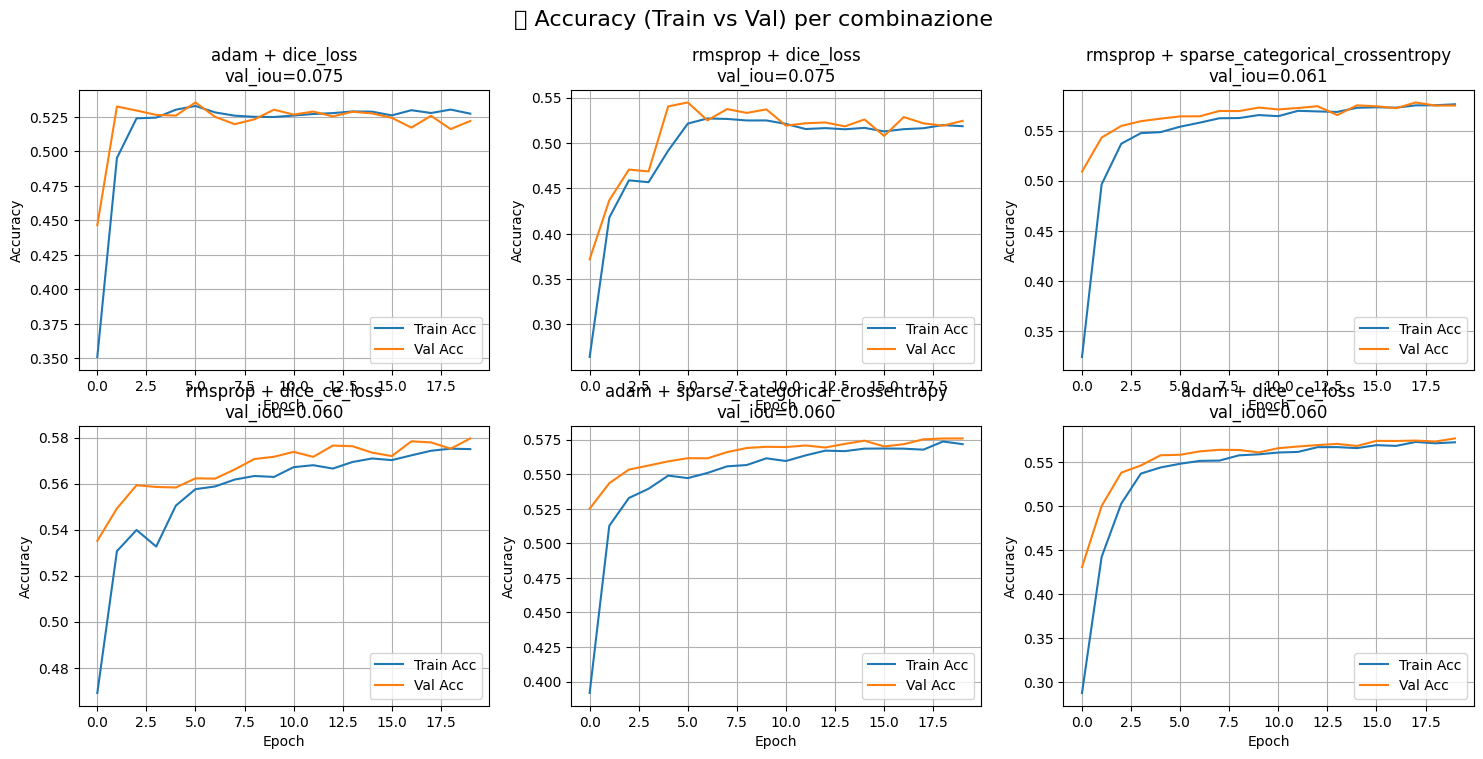

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


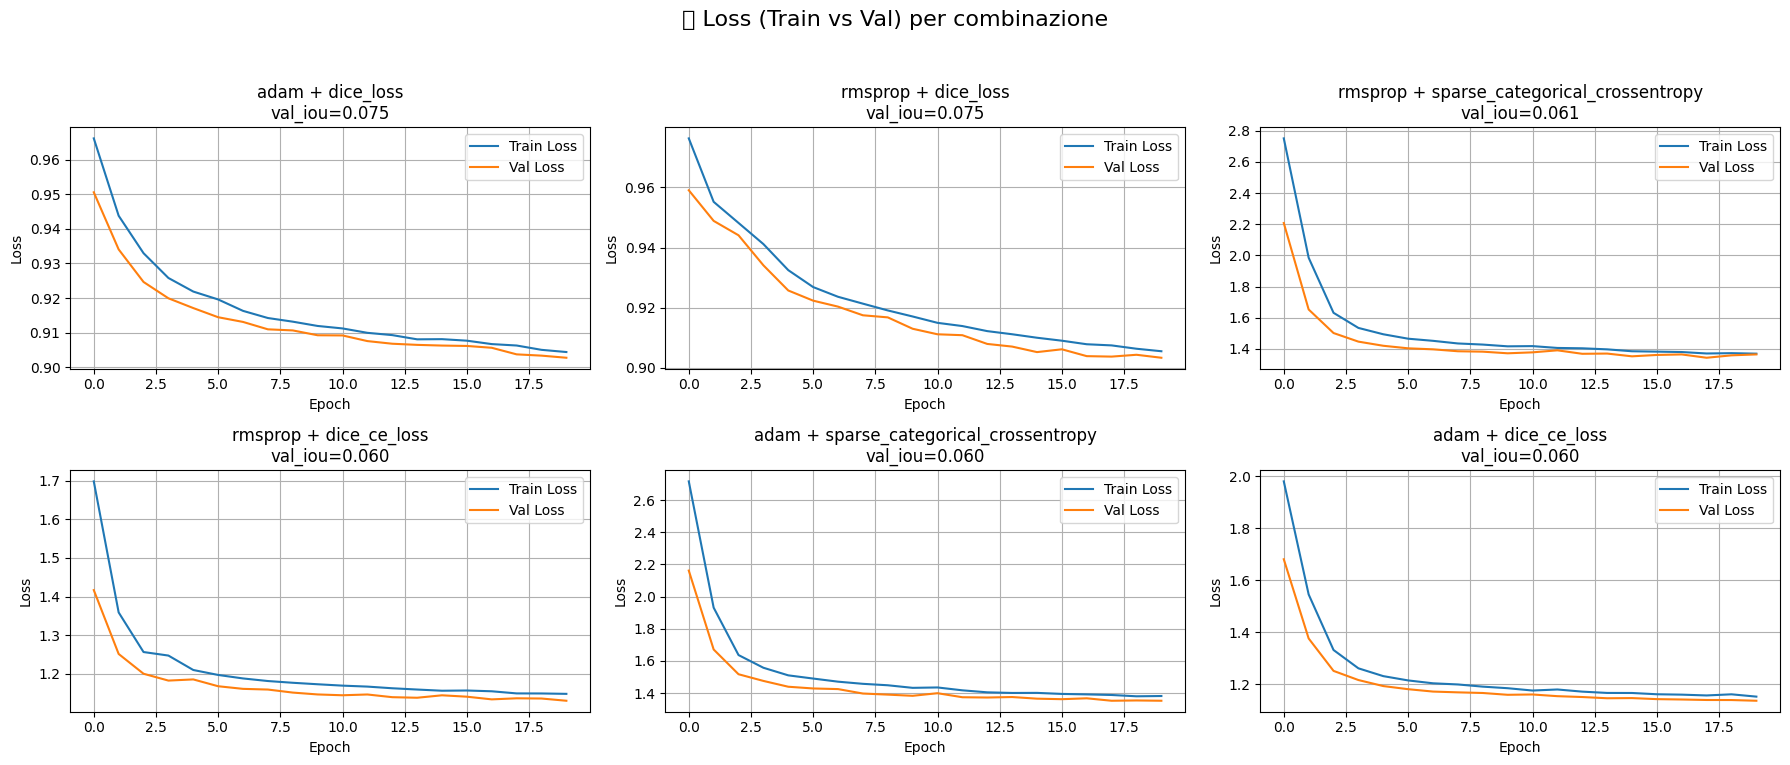

In [24]:
# Parametri
batch_size = 8
num_classes = 32

# Configurazioni da testare
optimizers = ['adam', 'rmsprop']
loss_functions = {
    'sparse_categorical_crossentropy': None,
    'dice_loss': dice_loss,
    'dice_ce_loss': dice_ce_loss

}

# Risultati
results = []

print("\nInizio test delle combinazioni...")
total_combinations = len(optimizers) * len(loss_functions)
combination_pbar = tqdm(total=total_combinations, desc="Combinazioni ottimizzatori/loss")


# Test combinazioni
for opt_name in optimizers:
    for loss_name, loss_fn in loss_functions.items():
        model = create_model(base_filters=16)

        # Creiamo un modello separato per la valutazione IoU
        # Versione alternativa con Lambda layer
        inference_model = keras.Model(
            inputs=model.input,
            outputs=tf.keras.layers.Lambda(
                lambda x: tf.argmax(x, axis=-1),
                name='argmax_output'
            )(model.output)
        )

        model.compile(
            optimizer=opt_name,
            loss=loss_fn if loss_fn else loss_name,
            metrics=['accuracy']
        )

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=20,
            verbose=1
        )

        # Calcolo manuale dell'IoU sul validation set
        iou_metric = tf.keras.metrics.MeanIoU(num_classes=num_classes)
        for x, y in val_ds:
            y_pred = inference_model.predict(x, verbose=0)
            iou_metric.update_state(y, y_pred)
        val_iou = iou_metric.result().numpy()

        # Salvataggio risultati
        results.append({
            'optimizer': opt_name,
            'loss': loss_name,
            'val_iou': val_iou,
            'model': model,
            'history': history.history
        })

        combination_pbar.update(1)


combination_pbar.close()
print_time_elapsed(start_time, "Test combinazioni completato")

# Trova il modello con la migliore IoU
best_result = max(results, key=lambda x: x['val_iou'])
best_model = best_result['model']

best_loss_name = best_result['loss']  # es. 'dice_ce', oppure 'dice_loss', oppure 'sparse_categorical_crossentropy'
best_optimizer_name = best_result['optimizer']


## RISULTATI

print("Miglior combinazione:")
print(f"Optimizer: {best_result['optimizer']}")
print(f"Loss: {best_result['loss']}")
print(f"Validation IoU: {best_result['val_iou']:.4f}")

# Ordinamento per val_iou decrescente
sorted_results = sorted(results, key=lambda x: x["val_iou"], reverse=True)

# Visualizzazione dei risultati
print("📊 RISULTATI DELLA GRID SEARCH (ordinati per val_iou):\n")
for idx, res in enumerate(sorted_results):
    print(f"#{idx + 1}")
    print(f"  Optimizer: {res['optimizer']}")
    print(f"  Loss Function: {res['loss']}")
    print(f"  Validation IoU: {res['val_iou']:.4f}")
    print(f"  Final Val Accuracy: {res['history']['val_accuracy'][-1]:.4f}")
    print(f"  Final Val Loss: {res['history']['val_loss'][-1]:.4f}")
    print("-" * 50)

# Mostra il migliore
best_model = sorted_results[0]["model"]
print("\n✅ Il modello migliore ha:")
print(f"   Optimizer = {sorted_results[0]['optimizer']}")
print(f"   Loss = {sorted_results[0]['loss']}")
print(f"   Validation IoU = {sorted_results[0]['val_iou']:.4f}")



# Ordinamento per val_iou decrescente
sorted_results = sorted(results, key=lambda x: x["val_iou"], reverse=True)

# Numero di modelli
n = len(sorted_results)

# Crea i grafici per Accuracy
fig_acc, axes_acc = plt.subplots(2, 3, figsize=(18, 8))
fig_acc.suptitle("📈 Accuracy (Train vs Val) per combinazione", fontsize=16)

# Crea i grafici per Loss
fig_loss, axes_loss = plt.subplots(2, 3, figsize=(18, 8))
fig_loss.suptitle("📉 Loss (Train vs Val) per combinazione", fontsize=16)

for i, result in enumerate(sorted_results):
    row = i // 3
    col = i % 3
    history = result["history"]

    title = f"{result['optimizer']} + {result['loss']}\nval_iou={result['val_iou']:.3f}"

    # Accuracy plot
    ax_acc = axes_acc[row][col]
    ax_acc.plot(history["accuracy"], label="Train Acc")
    ax_acc.plot(history["val_accuracy"], label="Val Acc")
    ax_acc.set_title(title)
    ax_acc.set_xlabel("Epoch")
    ax_acc.set_ylabel("Accuracy")
    ax_acc.legend()
    ax_acc.grid(True)

    # Loss plot
    ax_loss = axes_loss[row][col]
    ax_loss.plot(history["loss"], label="Train Loss")
    ax_loss.plot(history["val_loss"], label="Val Loss")
    ax_loss.set_title(title)
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    ax_loss.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [25]:
'''def build_model(hp):
    inputs = keras.Input(shape=(512, 512, 3))

    # Hyperparameters to optimize
    base_filters = hp.Choice('base_filters', values=[8, 16, 32])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    alpha = hp.Float('alpha', min_value=0.2, max_value=0.8, step=0.1)

    model = create_model()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=dice_ce_loss_wrapper(alpha),  # Combined loss
        metrics=[
            ArgmaxMeanIoU(num_classes=num_classes, name='iou'),
            'accuracy'
        ]
    )

    return model'''


def build_model_wrapper(best_loss_name, best_optimizer_name):
    def build_model(hp):
        base_filters = hp.Choice('base_filters', values=[8, 16, 32])
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # Solo i parametri rilevanti per la loss selezionata
        if best_loss_name == 'dice_ce_loss':
            alpha = hp.Float('alpha', min_value=0.2, max_value=0.8, step=0.1)
        elif best_loss_name == 'dice_loss':
            smooth = hp.Float('smooth', min_value=0.2, max_value=0.8, step=0.1)
        #elif best_loss_name == 'sparse_categorical_crossentropy':
            #ce_param = hp.Float('ce_param', min_value=0.0, max_value=0.5, step=0.05)

        # Costruzione modello
        model = create_model(base_filters=base_filters)

        optimizer_map = {
            'adam': keras.optimizers.Adam(learning_rate=learning_rate),
            'rmsprop': keras.optimizers.RMSprop(learning_rate=learning_rate),
        }
        optimizer = optimizer_map.get(best_optimizer_name)

        # Selezione loss function
        if best_loss_name == 'dice_ce_loss':
            loss_fn = dice_ce_loss_wrapper(alpha)
        elif best_loss_name == 'dice_loss':
            loss_fn = dice_loss_wrapper(smooth)
        elif best_loss_name == 'sparse_categorical_crossentropy':
            loss_fn = crossentropy_loss_wrapper()

        model.compile(
            optimizer=optimizer,
            loss=loss_fn,
            metrics=[ArgmaxMeanIoU(num_classes=32, name='iou'), 'accuracy']
        )

        return model

    return build_model

In [30]:
tuner = kt.Hyperband(
    build_model_wrapper(best_loss_name, best_optimizer_name),
    objective=kt.Objective("val_iou", direction="max"),
    max_epochs=20,
    factor=3,
    hyperband_iterations=1,
    directory='hyperparam_tuning',
    project_name='camvid_optim'
)

# Early stopping callback based on validation IoU
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou',
    patience=5,
    mode='max',
    restore_best_weights=True
)

start_time = time.time()
print("Starting hyperparameter search...")
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[stop_early]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Stampa i migliori iperparametri trovati
print(f"\n✅ Best hyperparameters found:")
print(f"- Base filters: {best_hps.get('base_filters')}")
print(f"- Learning rate: {best_hps.get('learning_rate')}")
print(f"- Best loss: {best_loss_name}")
print(f"- Best optimizer: {best_optimizer_name}")

# Stampa l’iperparametro della loss, solo se presente
if best_loss_name == 'dice_ce_loss':
    print(f"- Alpha (CE weight): {best_hps.get('alpha')}")
elif best_loss_name == 'dice_loss':
    print(f"- Smooth: {best_hps.get('smooth')}")
#elif best_loss_name == 'sparse_categorical_crossentropy':
    #print(f"- CE smoothing: {best_hps.get('ce_param')}")

print_time_elapsed(start_time, "Hyperparameter search completed")

# Salva i migliori iperparametri su file
with open('best_hyperparameters.txt', 'w') as f:
    f.write(f"base_filters: {best_hps.get('base_filters')}\n")
    f.write(f"learning_rate: {best_hps.get('learning_rate')}\n")
    f.write(f"loss: {best_loss_name}\n")
    f.write(f"optimizer: {best_optimizer_name}\n")
    if best_loss_name == 'dice_ce_loss':
        f.write(f"alpha: {best_hps.get('alpha')}\n")
    elif best_loss_name == 'dice_loss':
        f.write(f"smooth: {best_hps.get('smooth')}\n")
    #elif best_loss_name == 'sparse_categorical_crossentropy':
        #f.write(f"ce_param: {best_hps.get('ce_param')}\n")

# Estrai i trial validi
trials = [t for t in tuner.oracle.get_best_trials(num_trials=100) if t.score is not None]

results = []
for trial in trials:
    hp = trial.hyperparameters
    trial_data = {
        'trial_id': trial.trial_id,
        'val_iou': trial.score,
        'epochs': trial.best_step,
        'base_filters': hp.get('base_filters'),
        'learning_rate': hp.get('learning_rate'),
    }

    # Aggiungi il parametro specifico della loss, se esiste
    if best_loss_name == 'dice_ce_loss':
        trial_data['alpha'] = hp.get('alpha')
    elif best_loss_name == 'dice_loss':
        trial_data['smooth'] = hp.get('smooth')
    #elif best_loss_name == 'sparse_categorical_crossentropy':
        #trial_data['ce_param'] = hp.get('ce_param')

    results.append(trial_data)



# Crea DataFrame
df_results = pd.DataFrame(results)

# Ordina per IoU decrescente
df_results = df_results.sort_values('val_iou', ascending=False)

# Mostra i migliori 10 trial
print("\n📈 Top 10 trials sorted by val_iou:")
print(df_results.head(10).to_string(index=False))

# Salva su CSV
df_results.to_csv('tuning_trials_summary.csv', index=False)
print("\n💾 Results saved to 'tuning_trials_summary.csv'")

Reloading Tuner from hyperparam_tuning/camvid_optim/tuner0.json
Starting hyperparameter search...

✅ Best hyperparameters found:
- Base filters: 16
- Learning rate: 0.01
- Best loss: dice_loss
- Best optimizer: adam
- Smooth: 0.5
Hyperparameter search completed - Elapsed: 0.00s

📈 Top 10 trials sorted by val_iou:
trial_id  val_iou  epochs  base_filters  learning_rate  smooth
    0025 0.066396      12            16          0.010     0.5
    0013 0.065823       0            16          0.001     0.4
    0012 0.065526       0             8          0.001     0.2
    0028 0.065224       3             8          0.001     0.7
    0027 0.065158       5            16          0.001     0.3
    0015 0.064999       0            32          0.001     0.7
    0024 0.064006      12            16          0.001     0.5
    0017 0.063990       0             8          0.001     0.2
    0023 0.063624       4            16          0.001     0.5
    0016 0.063560      11            16          0.001 

In [46]:
print("\nTraining final model with best hyperparameters...")
model = tuner.hypermodel.build(best_hps)

csv_logger = keras.callbacks.CSVLogger('training_metrics.csv')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=[
        stop_early,
        TqdmCallback(verbose=1),
        keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_iou',
            mode='max'
        ),
        csv_logger
    ]
)


Training final model with best hyperparameters...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 100s 597ms/step - accuracy: 0.3356 - iou: 0.0352 - loss: 0.9344 - val_accuracy: 0.4825 - val_iou: 0.0429 - val_loss: 0.4693
Epoch 2/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.4821 - iou: 0.0475 - loss: 0.4506 - val_accuracy: 0.5158 - val_iou: 0.0535 - val_loss: 0.4545
Epoch 3/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 385ms/step - accuracy: 0.5099 - iou: 0.0566 - loss: 0.4479 - val_accuracy: 0.5311 - val_iou: 0.0584 - val_loss: 0.4505
Epoch 4/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 381ms/step - accuracy: 0.5237 - iou: 0.0591 - loss: 0.4418 - val_accuracy: 0.5161 - val_iou: 0.0576 - val_loss: 0.4512
Epoch 5/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 388ms/step - accuracy: 0.5131 - iou: 0.0614 - loss: 0.4455 - val_accuracy: 0.5052 - val_iou: 0.0606 - val_loss: 0.4473
Epoch 6/60
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 386ms/step - accuracy: 0.5123 - iou: 0.0634 - loss: 0.4385 - val_accuracy: 0.4973 - val_iou: 0.0608 - val_loss: 0.4470
Epoch 7/60
93/93 ━━━━━━━━━━━━━━━━

In [32]:
print("\nEvaluating on test set...")
test_loss, test_iou, test_acc = model.evaluate(test_ds)
print(f"Test IoU: {test_iou:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Save test results to file
with open('final_results.txt', 'w') as f:
    f.write(f"Test IoU: {test_iou}\n")
    f.write(f"Test Accuracy: {test_acc}\n")
    f.write(f"Test Loss: {test_loss}\n")


Evaluating on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5303 - iou: 0.0771 - loss: 0.4226
Test IoU: 0.0708
Test Accuracy: 0.5288
Test Loss: 0.4217


In [45]:
# 1. Caricamento delle informazioni delle classi
class_info = {}
with open('/kaggle/input/class-dict/class_dict.csv', mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        class_info[row['name']] = {
            'rgb': (int(row['r']), int(row['g']), int(row['b'])),
            'description': row['name']
        }

# 2. Integrazione con il tuo codice originale
ious_per_class = []
class_names = list(class_info.keys())  # Lista ordinata dei nomi delle classi

for cls in range(len(class_names)):  # Usiamo len(class_names) invece di num_classes
    # Metric IoU per la singola classe
    metric = tf.keras.metrics.MeanIoU(num_classes=2)

    # Cicla sul test set
    for x_batch, y_batch in test_ds:
        y_pred_batch = model.predict(x_batch)
        y_pred_labels = tf.argmax(y_pred_batch, axis=-1)

        # Maschere binarie
        y_true_cls = tf.cast(tf.equal(y_batch, cls), tf.int32)
        y_pred_cls = tf.cast(tf.equal(y_pred_labels, cls), tf.int32)

        metric.update_state(y_true_cls, y_pred_cls)

    iou = metric.result().numpy()
    ious_per_class.append(iou)

    # Stampa con informazioni aggiuntive
    print(f"IoU per {class_names[cls]} (classe {cls}, RGB {class_info[class_names[cls]]['rgb']}): {iou:.4f}")

# Media finale
print(f"\nIoU medio su tutte le classi: {np.mean(ious_per_class):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
IoU per Void (classe 0, RGB (0, 0, 0)): 0.4930
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━

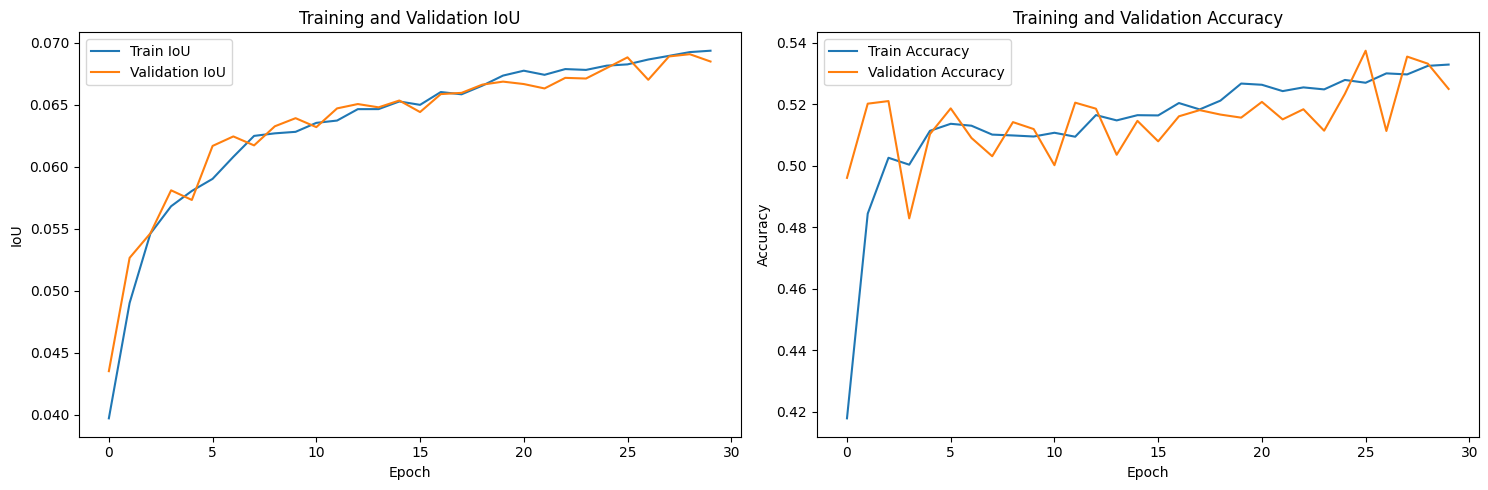

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['iou'], label='Train IoU')
plt.plot(history.history['val_iou'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


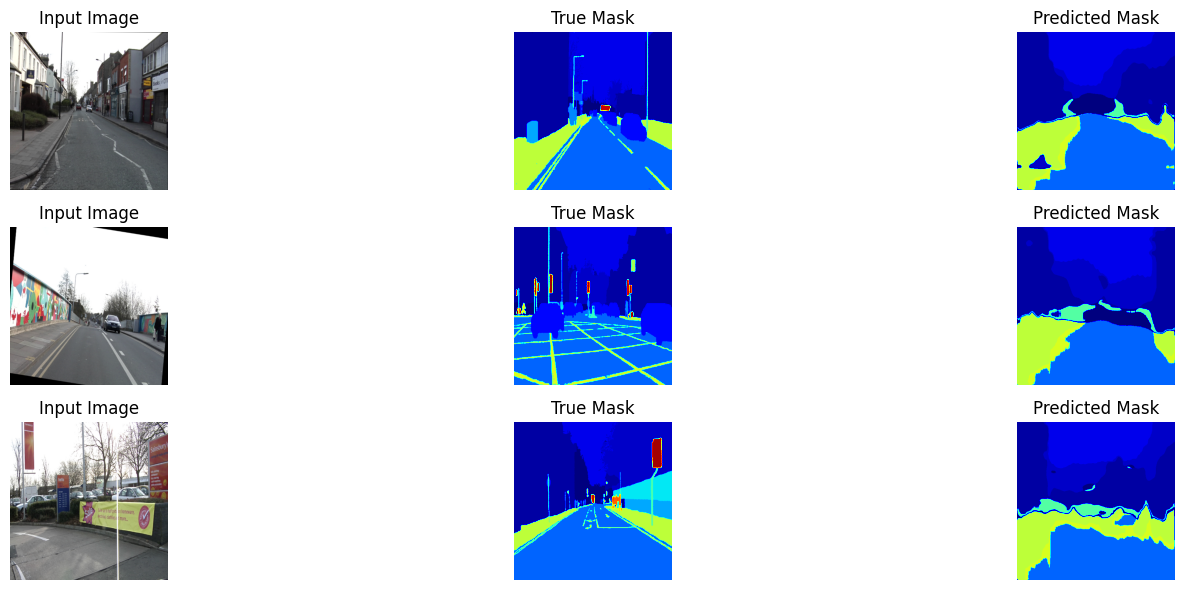

In [35]:
def plot_sample_prediction():
    sample_images, sample_masks = next(iter(test_ds.take(1)))
    pred_masks = model.predict(sample_images)
    pred_masks = tf.argmax(pred_masks, axis=-1)

    plt.figure(figsize=(18, 6))
    for i in range(3):
        plt.subplot(3, 3, i*3+1)
        plt.imshow(sample_images[i])
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(3, 3, i*3+2)
        plt.imshow(sample_masks[i], cmap='jet', vmin=0, vmax=num_classes-1)
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(3, 3, i*3+3)
        plt.imshow(pred_masks[i], cmap='jet', vmin=0, vmax=num_classes-1)
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300)
    plt.show()

plot_sample_prediction()